<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Aprendizaje Supervisado -> Grupo 5 Cohorte 2</h1>

Patricia Loto

Sandra Monica Olariaga

Veronica Bornancini

Fernandez María Soledad   


# Diplodatos Kaggle Competition

We present this peace of code to create the baseline for the competition, and as an example of how to deal with these kind of problems. The main goals are that you:

1. Learn
2. Try different models and see which one fits the best the given data
3. Get a higher score than the given one in the current baseline example
4. Try to get the highest score in the class :)

In [1]:
# Import the required packages
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats 
import seaborn as sns 
import warnings

from sklearn.model_selection import train_test_split 
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import ExtraTreesRegressor
#from xgboost import XGBRegressor
import xgboost as xgb
from IPython.display import display_html
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from imblearn.ensemble import BalancedBaggingClassifier

Read the *original* dataset...

In [2]:
original_df = pd.read_csv('../data/train.csv')
#original_df = pd.read_csv(r'E:\anaconda3\envs\aprendizajesupervisado\train.csv')

### 1. Learn

#### 1.1 Verificamos columnas con sus datos

In [3]:
# 1) Averiguamos el nombre de cada variable presente en el dataset
original_df.columns

Index(['TripType', 'VisitNumber', 'Weekday', 'Upc', 'ScanCount',
       'DepartmentDescription', 'FinelineNumber'],
      dtype='object')

In [4]:
# 2) Inspeccionamos las primeras filas del dataset
original_df[:5]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,8,9,Friday,1.070081e+09,1,IMPULSE MERCHANDISE,115.0
2,8,9,Friday,3.107000e+03,1,PRODUCE,103.0
3,8,9,Friday,4.011000e+03,1,PRODUCE,5501.0
4,8,10,Friday,6.414410e+09,1,DSD GROCERY,2008.0


* **TripType** is the column that we should predict. That column is not present in the test set

In [5]:
# 3) Consultamos el tipo de dato de cada variable
original_df.dtypes

TripType                   int64
VisitNumber                int64
Weekday                   object
Upc                      float64
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
dtype: object

In [6]:
# 4) Pedimos una descripción de los datos. Por defecto se muestra la información de las variables numéricas
original_df.describe().round()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,453411.0,453411.0,4.505590e+05,453411.0,450559.0
mean,58.0,95910.0,3.075243e+10,1.0,3727.0
std,156.0,55400.0,9.163940e+10,1.0,2780.0
min,3.0,5.0,8.340000e+02,-10.0,0.0
25%,27.0,49390.0,3.400004e+09,1.0,1404.0
50%,39.0,96781.0,7.056082e+09,1.0,3352.0
75%,40.0,143930.0,3.013201e+10,1.0,5501.0
max,999.0,191347.0,9.789707e+11,71.0,9998.0


In [7]:
# 5) Como tenemos variables tipo Object, pedimos ver un resumen del resto de los datos (no numéricos)
original_df.describe(include=['object'])

,Weekday,DepartmentDescription
count,453411,452439
unique,7,68
top,Sunday,GROCERY DRY GOODS
freq,94602,49134


In [8]:
# 6) Averiguamos los posibles valores que toman las variables tipo Object
# Variable Weekday
set(original_df.Weekday)

{'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'}

In [9]:
# Variable DepartmentDescription
set(original_df.DepartmentDescription)

{'1-HR PHOTO',
 'ACCESSORIES',
 'AUTOMOTIVE',
 'BAKERY',
 'BATH AND SHOWER',
 'BEAUTY',
 'BEDDING',
 'BOOKS AND MAGAZINES',
 'BOYS WEAR',
 'BRAS & SHAPEWEAR',
 'CAMERAS AND SUPPLIES',
 'CANDY, TOBACCO, COOKIES',
 'CELEBRATION',
 'COMM BREAD',
 'CONCEPT STORES',
 'COOK AND DINE',
 'DAIRY',
 'DSD GROCERY',
 'ELECTRONICS',
 'FABRICS AND CRAFTS',
 'FINANCIAL SERVICES',
 'FROZEN FOODS',
 'FURNITURE',
 'GIRLS WEAR, 4-6X  AND 7-14',
 'GROCERY DRY GOODS',
 'HARDWARE',
 'HEALTH AND BEAUTY AIDS',
 'HOME DECOR',
 'HOME MANAGEMENT',
 'HORTICULTURE AND ACCESS',
 'HOUSEHOLD CHEMICALS/SUPP',
 'HOUSEHOLD PAPER GOODS',
 'IMPULSE MERCHANDISE',
 'INFANT APPAREL',
 'INFANT CONSUMABLE HARDLINES',
 'JEWELRY AND SUNGLASSES',
 'LADIES SOCKS',
 'LADIESWEAR',
 'LARGE HOUSEHOLD GOODS',
 'LAWN AND GARDEN',
 'LIQUOR,WINE,BEER',
 'MEAT - FRESH & FROZEN',
 'MEDIA AND GAMING',
 'MENS WEAR',
 'MENSWEAR',
 'OFFICE SUPPLIES',
 'OPTICAL - FRAMES',
 'OPTICAL - LENSES',
 'OTHER DEPARTMENTS',
 'PAINT AND ACCESSORIES',
 'PER

In [10]:
# 7) Averiguaremos si hay valores nulos (nan)
# Cuantificamos por Tipo de Viaje (TripType)
s_triptype = original_df.groupby("VisitNumber").TripType.mean().value_counts()
df_triptype = s_triptype.to_frame(name="TripType")
df_triptype = df_triptype.sort_values('TripType')
df_triptype_styler = df_triptype.style.set_table_attributes("style='display:inline;padding-left:20px;'").set_caption('Cantidad por TRIPTYPE')

display_html(df_triptype_styler._repr_html_(), raw=True)

,TripType
14,4
23,98
12,187
4,245
19,252
29,313
28,331
26,355
18,384
41,412


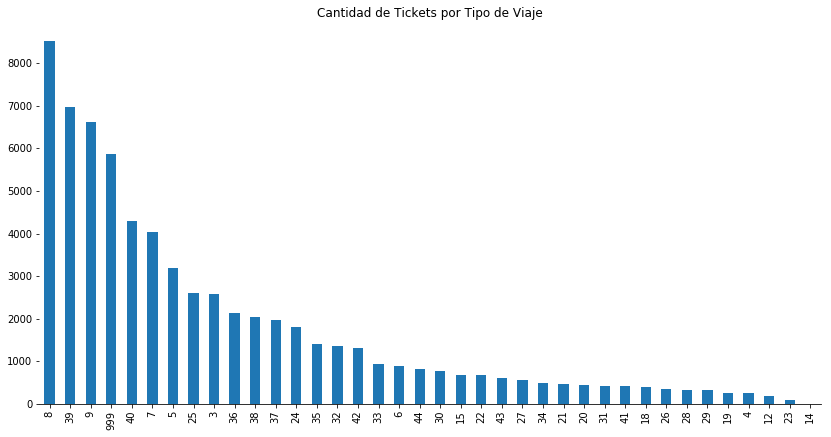

In [11]:
# 8) Agrupamos por VisitNumber para realizar un conteo de los valores de la variable TripType 
plt.figure (figsize=(14,7))
plt.title('Cantidad de Tickets por Tipo de Viaje')
sns.despine(left=True)
original_df.groupby("VisitNumber").TripType.mean().value_counts().plot(kind='bar')

* **Observación:** Los datos se encuentran desbalanceados con respecto a la cantidad de registros por TripType

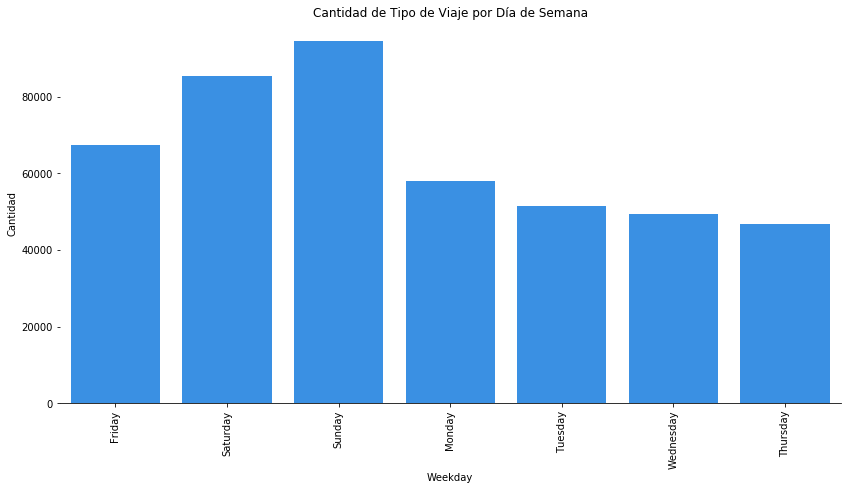

In [12]:
plt.figure (figsize=(14,7))
plt.title('Cantidad de Tipo de Viaje por Día de Semana')
sns.countplot(data=original_df, x='Weekday', color='dodgerblue')
plt.xticks(rotation=90)
plt.ylabel('Cantidad')
sns.despine(left=True)

#### 1.2 Verificacion de Valores Nulos

In [15]:
# 1) Chequeamos si hay valores nulos y si es así cuantos hay
v_nan =np.zeros((7,1))

v_nan[0] = original_df.TripType.isnull().sum()
v_nan[1] = original_df.VisitNumber.isnull().sum()
v_nan[2] = original_df.Weekday.isnull().sum()
v_nan[3] = original_df.Upc.isnull().sum()
v_nan[4] = original_df.ScanCount.isnull().sum()
v_nan[5] = original_df.DepartmentDescription.isnull().sum()
v_nan[6] = original_df.FinelineNumber.isnull().sum()

df_nan = pd.DataFrame(v_nan, index=['TripType_NaN','VisitNumber_NaN','Weekday_NaN','Upc_NaN','ScanCount_NaN','DepartmentDescription_NaN','FinelineNumber_NaN']).round()
df_nan.columns = ['Nulos']

df_nan_styler = df_nan.style.set_table_attributes("style='display:inline;padding-left:20px;'").set_caption('Nulos en el DF')

display_html(df_nan_styler._repr_html_(), raw=True)

,Nulos
TripType_NaN,0
VisitNumber_NaN,0
Weekday_NaN,0
Upc_NaN,2852
ScanCount_NaN,0
DepartmentDescription_NaN,972
FinelineNumber_NaN,2852


In [20]:
# 2) Chequeamos si los registros con valores nulos se corresponden 
(original_df.DepartmentDescription.isnull().sum(),
 (original_df.DepartmentDescription.isnull() & original_df.Upc.isnull() & original_df.FinelineNumber.isnull()).sum()) # si es nan el departamento los otros dos atributos lo son

(972, 972)

* **Observaciones:** 
* Tenemos tres variables con valores nulos (Upc, DepartmentDescription y FinelineNumber).
* La cantidad de nulos para las variables Upc y FinelineNumber es el mismo.
* Verificamos que cuando DepartmentDescription es NaN, las columnas Upc y FinelineNumber también lo son.

In [22]:
original_df[original_df.Upc.isnull()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
739,999,484,Friday,NaN,-2,NaN,NaN
740,999,484,Friday,NaN,-2,NaN,NaN
900,5,585,Friday,NaN,1,PHARMACY RX,NaN
944,5,619,Friday,NaN,1,PHARMACY RX,NaN
945,5,619,Friday,NaN,1,PHARMACY RX,NaN
946,5,619,Friday,NaN,1,PHARMACY RX,NaN
1292,32,845,Friday,NaN,1,NaN,NaN
1293,32,845,Friday,NaN,1,NaN,NaN
1577,40,1004,Friday,NaN,1,NaN,NaN
1770,5,1073,Friday,NaN,1,PHARMACY RX,NaN


In [24]:
(original_df.Upc.isnull().sum(),
 original_df.FinelineNumber.isnull().sum(),
 (original_df.FinelineNumber.isnull() & original_df.Upc.isnull()).sum())

(2852, 2852, 2852)

In [26]:
df_notna = original_df[pd.notnull(original_df['DepartmentDescription'])]
print(df_notna.FinelineNumber.isnull().sum())
print(df_notna.Upc.isnull().sum())

1880
1880


**Observaciones:** 
* Puede darse el caso que cuando la variable Upc es nula, la variable DepartmentDescription no lo sea.
* Notamos que los registros con valores nulos de las variables Upc y FinelineNumber se corresponden.
* La cantidad de registros con valores no nulos de ambas variables, también se corresponde.

#### 1.3 Verificacion y eliminacion de Outliers

In [ ]:
df_outl = df_notna.loc[:, ['TripType', 'VisitNumber', 'Upc', 'ScanCount']]

for feature in df_outl.columns:
    
    if feature != 'TripType':
        plt.figure (figsize=(17,6))
        sns.boxplot(data=df_outl, color='dodgerblue', x='TripType', y=feature)
        #plt.title('Boxplot para ', feature)
        plt.ylabel(feature)
        plt.xlabel('TripType')
        sns.despine()
        plt.show()

Podemos notar que para la variable ScanCount existen ciertos outliers de algunos Tipos de Viaje al Supermercado (TripType)

In [ ]:
# Filtrado de outliers 
def clean_outliers(dataset, column_name):
    """Returns dataset removing the outlier rows from column @column_name."""
    interesting_col = dataset[column_name]
    mask_var_outlier = (
        np.abs(interesting_col - interesting_col.mean()) <= (15 * interesting_col.std()))
    return dataset[mask_var_outlier]

In [ ]:
df_clean = clean_outliers(df_notna, "ScanCount")
print("Filas removidas", len(df_notna) - len(df_clean))

In [ ]:
plt.figure (figsize=(17,6))
sns.boxplot(data=df_clean, color='dodgerblue', x='TripType', y=feature)
plt.ylabel('ScanCount')
plt.xlabel('TripType')
sns.despine()
plt.show()

In [ ]:
df_group = original_df.groupby(by='VisitNumber', as_index=False).agg({'Weekday': pd.Series.nunique})

print(df_group['Weekday'].unique())

Al agrupar por VisitNumber y verificar los valores de Weekday notamos que todos los tickets son únicos para la feature Weekday

In [ ]:
df_ddNaN = original_df[original_df.DepartmentDescription.isna()]

#print(df_ddNaN['TripType'].unique())

# to count the TripType values, we have to group the visits by VisitNumber
plt.figure (figsize=(12,6))
plt.title('Distribucion TripType para DepartmentDescription Nulos')
sns.despine(left=True)
sns.countplot(data=df_ddNaN, x='TripType', color='dodgerblue')

Para el caso de DepartmentDescription vemos que existe una distribucion no uniforme en la clasificacion de TripType 

In [ ]:
df_group = original_df.groupby(by='VisitNumber', as_index=False).agg({'TripType': pd.Series.nunique})

print(df_group['TripType'].unique())    

Al agrupar por VisitNumber y verificar los valores de TripType notamos tambien que todos los tickets son únicos para esta feature

In [ ]:
warnings.filterwarnings('ignore')

original_df.Upc.mode()[0]

df_notna.fillna({'Upc': original_df.Upc.mode()[0]}, inplace=True)

df_notna.Upc.isna().sum()

Reemplazamos los NaN de la feature UPC por la moda ya que se trata de una variable numerica discreta

Lo mismo notamos al agrupar por VisitNumber notamos que el valor TripType es único por ticket 

In [ ]:
y = original_df.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType
y.shape

Our last step in this analysis is to see how balanced is the data...

In [ ]:
bins = set(original_df.TripType) ###### esto para que es

Create a function to load the datasets.

#### 1.4  Some important decisions made here:

#### 1.4.1. We will use one hot encoding for Weekday and DepartmentDescription. All transformations are applied to the training and testing datasets... 

#### 1.4.2. No vamos a filtrar los NaN's de la feature DepartmentDescription

#### 1.4.3. Eliminamos la feature FinelineNumber porque no parece relevante para el procesoo

#### 1.4.4. Reemplazamos los valores NaN de la feature Upc por la moda ya que se trata de una variable numerica discreta

#### 1.4.5. We may have multiple records for one single visit and the goal is to classify all those records the exact same way. Therefore, we will prepare the data in a way that all the information for a visit is in the same record.

#### 1.4.6. Eliminaremos los outliers de la variable ScanCount con más de 15 desviaciones de la media

#### 1.4.7. Based on the last bullet, we will count the DepartmentDescription for all items acquired in the same visit.

#### 1.4.8. Para probar los distintos modelos tomaremos la mitad del dataset en forma aleatoria para que la verificacion y validacion de cada modelo no sea tan lenta

The following operations will be performed in a function. Anyway, we present them here so that we can see them in action:

First, we drop the columns. We include TripType as we are going to treat it differently:

In [ ]:
df = original_df.drop(["FinelineNumber", "TripType"], axis=1)

df

Now, we create the dummy columns

In [ ]:
df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)

df

Now, we group by the VisitNumber and Weekday (they should be the same), and add all values for ScanCount, and the one-hot encoding of DepartmentDescriptioin

In [ ]:
df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()

df

In [ ]:
df = pd.get_dummies(df, columns=["Weekday"], dummy_na=True)
df

La funcion que creemos contendra los puntos definidos para cada una de las decisiones que se tomaron sobre el dataset

In [ ]:
def transform_data(train_data_fname, test_data_fname):
    
    df_train = pd.read_csv(train_data_fname)#, nrows=200000)
    y = df_train
    df_train['is_train_set'] = 1
    df_test = pd.read_csv(test_data_fname)#, nrows=100000)
    df_test['is_train_set'] = 0
    
    # 1.4.7
    # we  get the TripType for the train set. To do that, we group by VisitNumber and
    # then we get the max (or min or avg)
    # Para el set de test saco las columnas DepartmentDescription en NaN
    y = y[pd.notnull(y['DepartmentDescription'])]
    # Elimino los outliers
    y_clean = clean_outliers(y, "ScanCount")
    y = y_clean
    
    # Agrupo el dataset
    y = y.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType
    
    # the concat is done so that we have the same columns for both datasets
    # after one-hot encoding
    df = pd.concat([df_train, df_test])
    
    # 1.4.2 Eliminamos los nulos de la columna DepartmentDescription
    df_notna = df[pd.notnull(df['DepartmentDescription'])]
    
    # the next three operations are the ones we have just presented in the previous lines
    
    # 1.4.3
    # drop the columns we won't use (it may be good to use them somehow)
    #df = df.drop(["FinelineNumber"], axis=1)
    df_notna = df_notna.drop(["FinelineNumber"], axis=1)
    
    # 1.4.4 Reemplazamos los valores faltantes de Upc por la Moda
    #df.fillna({'Upc': original_df.Upc.mode()[0]}, inplace=True)
    df_notna.fillna({'Upc': original_df.Upc.mode()[0]}, inplace=True)

    # 1.4.1
    # one-hot encoding for the DepartmentDescription
    #df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)
    df_notna = pd.get_dummies(df_notna, columns=["DepartmentDescription"], dummy_na=True)
    
    # 1.4.6 Eliminamos los outliers de ScanCount
    #df_clean = clean_outliers(df, "ScanCount")
    df_clean = clean_outliers(df_notna, "ScanCount")
            
    # 1.4.5
    # now we add the groupby values
    df_clean = df_clean.groupby(["VisitNumber", "Weekday"], as_index=False).sum()
    
    # 1.4.1
    # finally, we do one-hot encoding for the Weekday
    df_clean = pd.get_dummies(df_clean, columns=["Weekday"], dummy_na=True)

    # get train and test back
    df_train = df_clean[df_clean.is_train_set != 0]
    df_test = df_clean[df_clean.is_train_set == 0]

    # we remove the TripType now, and concat training and testing data  NO SE SI VA A HACER LO MISMO....
    df_train = df_train.drop("TripType", axis=1)
    df_test = df_test.drop("TripType", axis=1)
    
    X = df_train.drop(["is_train_set"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set"], axis=1)

    return X, y, XX, yy

Load the data...

In [ ]:
X, y, XX, yy = transform_data("../data/train.csv", "../data/test.csv")
#X, y, XX, yy = transform_data(r"E:\anaconda3\envs\aprendizajesupervisado\train.csv", r"E:\anaconda3\envs\aprendizajesupervisado\test.csv")

In [ ]:
X.shape, y.shape, XX.shape

### 2. Try different models and see which one fits the best the given data

**DESBALANCEO DE DATOS**
Podemos optar por alguno de estos dos metodos para balancearlos

*Ajuste de Parámetros del modelo*: Consiste en ajustar parametros ó metricas del propio algoritmo para intentar equilibrar a la clase minoritaria penalizando a la clase mayoritaria durante el entrenamiento. Ejemplos on ajuste de peso en árboles, también en logisticregression tenemos el parámetro class_weight= “balanced” que utilizaremos en este ejemplo. No todos los algoritmos tienen estas posibilidades. En redes neuronales por ejemplo podríamos ajustar la métrica de Loss para que penalice a las clases mayoritarias.

*Balanced Ensemble Methods*: Utiliza las ventajas de hacer ensamble de métodos, es decir, entrenar diversos modelos y entre todos obtener el resultado final (por ejemplo “votando”) pero se asegura de tomar muestras de entrenamiento equilibradas.

Create the model and evaluate it

#### 2.1 Dividir los dataset en entrenamiento y test

In [ ]:
# split training dataset into train and "validation" 
# (we won't be using validation set in this example, because of the cross-validation;
# but it could be useful for you depending on your approach)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=0)

In [ ]:
# results dataframe is used to store the computed results
res_acc_df = pd.DataFrame(columns=('description', 'clf', 'best_acc'))

#### 2.2 Modelo Decision Tree

##### 2.2.1 Setear Hiperparametros, entrenar y seleccionar el Mejor Modelo

In [ ]:
# we will use a DesicionTree to classify and GridSearch to determine the parameters
tree_param = {
              'criterion':('gini', 'entropy'), 
              'min_samples_leaf':(1, 2, 5),
              'min_samples_split':(2, 3, 5, 10, 50, 100),
              'random_state':(0, 1, 2, 42)
             }

model_tree = DT()

tree_clf = GridSearchCV(model_tree, tree_param, cv=3, scoring='accuracy') #scoring='balanced_accuracy')

In [ ]:
tree_clf.fit(X_train, y_train)

In [ ]:
# results dataframe is used to store the computed results
results = tree_clf.cv_results_
    
df = pd.DataFrame(results)
df_result = df[['param_criterion', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]
df_result

In [ ]:
# Seleccionar el modelo con mean_test_score mas alto y menor varianza
df_bm = df_result[df_result['rank_test_score'] == 1]
df_bm

In [ ]:
best_tree_clf = tree_clf.best_estimator_
bestpar = tree_clf.best_params_

print('Mejor Modelo\n', best_tree_clf)
print('Mejores Parametros\n', bestpar)

In [ ]:
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
res_acc_df = res_acc_df.append({'description': 'modelo dt first run', 'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)

In [ ]:
res_acc_df

#### 2.3 Modelo Naive Bayes

##### 2.3.1 Setear Hiperparametros, entrenar y seleccionar el Mejor Modelo

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=0)

In [ ]:
X_train.ScanCount[X_train.ScanCount < 0 ] = 0

In [ ]:
modelNB = MultinomialNB().fit(X_train, y_train)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
y_train_pred=modelNB.predict(X_train)

In [ ]:
acc_score = accuracy_score(y_train, y_train_pred)

print('Naive Bayes accuracy: ', acc_score)
res_acc_df = res_acc_df.append({'description': 'modelo nv second run', 'clf': 'default', 'best_acc': acc_score}, ignore_index=True)

In [ ]:
res_acc_df

#### 2.4 Modelo Random Forest

##### 2.4.1 Setear Hiperparametros, entrenar y seleccionar el Mejor Modelo

In [ ]:
rf_param = {
              'criterion':('gini', 'entropy'), 
              'min_samples_leaf':(1, 2, 5),
              'min_samples_split':(2, 3, 5, 10, 50, 100),
              'random_state': [0,1,2],
              'n_estimators': [50,75,100],
              'class_weight' : ('balanced', 'balanced_subsample')
            }

model_rf = RandomForestClassifier()
rf_clf = GridSearchCV(model_rf, rf_param, cv=3, scoring='accuracy') #scoring='balanced_accuracy')

In [ ]:
rf_clf.fit(X_train, y_train)

In [ ]:
# results dataframe is used to store the computed results
results = rf_clf.cv_results_
    
df = pd.DataFrame(results)
df_result = df[['param_criterion', 'param_min_samples_leaf', 'param_min_samples_split', 'param_random_state', 'param_n_estimators', 'param_class_weight', 'mean_test_score', 'std_test_score', 'rank_test_score']]
df_result

In [ ]:
# Seleccionar el modelo con mean_test_score mas alto y menor varianza
df_bm = df_result[df_result['rank_test_score'] == 1]
df_bm

In [ ]:
best_rf_clf = rf_clf.best_estimator_
bestpar = rf_clf.best_params_

print('Mejor Modelo\n', best_rf_clf)
print('Mejores Parametros\n', bestpar)

In [ ]:
print('Best Regression Logistic accuracy: ', rf_clf.best_score_)
res_acc_df = res_acc_df.append({'description': 'modelo rf third run', 'clf': rf_clf, 'best_acc': rf_clf.best_score_}, ignore_index=True)

In [ ]:
res_acc_df

#### 2.5 Modelo Boosting with xgboost

##### 2.5.1 Setear Hiperparametros, entrenar y seleccionar el Mejor Modelo

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(X_train,y_train)

In [ ]:
y_train_pred = xg_reg.predict(X_train)

In [ ]:
mse = mean_squared_error(y_train, y_train_pred)
print("MSE: %f" % (mse))

In [ ]:
y_valid_pred = xg_reg.predict(X_valid)

In [ ]:
y_valid.shape, y_valid_pred.shape

In [ ]:
pred=[round(value) for value in y_valid_pred]

In [ ]:
acc_score = accuracy_score(y_valid, pred)

In [ ]:
print('Boosting accuracy: ', acc_score)
res_acc_df = res_acc_df.append({'description': 'modelo boosting fourth run', 'objective =reg:squarederror, colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10': 'default', 'best_acc': acc_score}, ignore_index=True)

In [ ]:
res_acc_df

In [ ]:
X.shape, XX.shape

#### 2.6 Modelo Ensemble with DT

##### 2.6.1 Setear Hiperparametros, entrenar y seleccionar el Mejor Modelo

In [ ]:
bbc = BalancedBaggingClassifier(base_estimator=DT(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

In [ ]:
#Train the classifier.
bbc.fit(X_train, y_train)

In [ ]:
y_valid_pred = bbc.predict(X_valid)

In [ ]:
y_valid.shape, y_valid_pred.shape

In [ ]:
pred=[round(value) for value in y_valid_pred]

In [ ]:
acc_score = accuracy_score(y_valid, pred)

In [ ]:
print('Ensemble accuracy: ', acc_score)
res_acc_df = res_acc_df.append({'description': 'modelo ensemble fifth run', 'clf': 'base_estimator=DT(), sampling_strategy=auto, replacement=False, random_state=0', 'best_acc': acc_score}, ignore_index=True)

**And finally**, we predict the unknown label for the testing set

The last thing we do is generating a file that should be *submitted* on kaggle

In [ ]:
#submission = pd.DataFrame(list(zip(XX.VisitNumber, yy)), columns=["VisitNumber", "TripType"])

In [ ]:
#submission.to_csv("../data/submission.csv", header=True, index=False)

In [ ]:
#submission